In [1]:
from typing import *
import numpy as np

from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
sim = AerSimulator()

from util import zero, one, Pretty

# Foundations II: Measurement in Multi-Qubit Systems

In this notebook, we'll introduce **measurement** on multi-qubit systems via **measurement operators**.

References
1. [Quantum Computation and Quantum Information: Chapter 2.2.3, Nielsen and Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview)

## Born Rule

We can generalize the **Born rule** to the multi-qubit setting. In particular, if

$$
|q\rangle = \sum_{i=1}^n \alpha_i |\overline{i}\rangle \,,
$$

then we obtain $\overline{i}$ with probability $|\alpha_i|^2$.

### Example

Let's reason this through using the Bell state

\begin{align*}
\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle \,.
\end{align*}

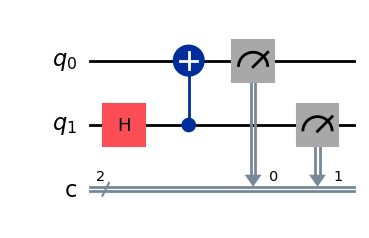

In [2]:
qc_e1 = QuantumCircuit(2, 2)
qc_e1.h(1)
qc_e1.cx(1, 0)
qc_e1.measure(0, 0); qc_e1.measure(1, 1)
qc_e1.draw(output="mpl", style="iqp")

After measurement, we obtain
1. $|00\rangle$ with probability $0.5$ and
2. $|11\rangle$ with probability $0.5$.

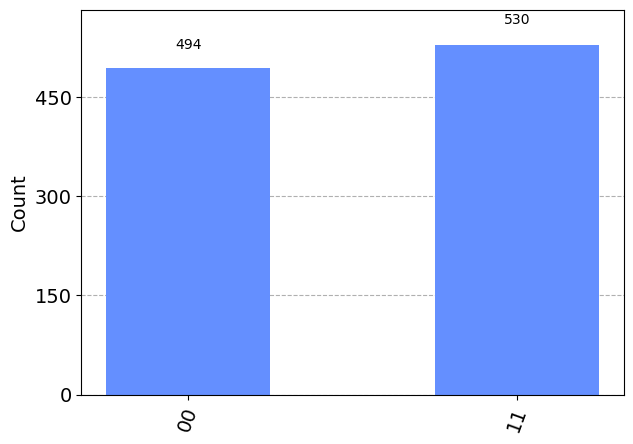

In [3]:
results = sim.run(qc_e1, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

### Partially Measuring a System

In a multi-qubit setting, we can also choose to only measure one of the qubits. For instance, in the example above, we may choose to only measure one of the qubits (shown below). To describe this state of affairs, we can introduce measurement more generally via **measurement operators**.

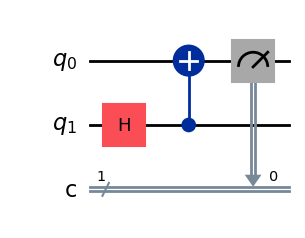

In [4]:
qc_e1 = QuantumCircuit(2, 1)
qc_e1.h(1)
qc_e1.cx(1, 0)
qc_e1.measure(0, 0)
qc_e1.draw(output="mpl", style="iqp")

## Measurement Operators

A square matrix $\Pi$ is called a **measurement operator** if
1. $\Pi = \Pi^\dagger$, i.e., $\Pi$ is **Hermitian**.
2. $\Pi^2 = \Pi$, i.e., $\Pi$ is **idempotent**.

### Examples

We give a few examples of measurement operators now.

In [5]:
Pi1 = np.array([
   [1.0, 0.0],
   [0.0, 1.0] 
])
print("Hermitian check", np.allclose(Pi1, np.conjugate(Pi1.transpose())))
print("Idempotent check", np.allclose(Pi1 @ Pi1, Pi1))

Hermitian check True
Idempotent check True


In [6]:
Pi2 = np.array([
   [1.0, 0.0],
   [0.0, 0.0] 
])
print("Hermitian check", np.allclose(Pi2, np.conjugate(Pi2.transpose())))
print("Idempotent check", np.allclose(Pi2 @ Pi2, Pi2))

Hermitian check True
Idempotent check True


### Measurement Operators from Orthogonal Vectors

Given an orthogonal set of vectors $\{\psi_1, \dots, \psi_n\}$, the matrix

$$
\sum_{i=1}^n |\psi_i \rangle \langle \psi_i|
$$

is a measurement operator. This gives us an easy to construct measurement operators since we can choose the orthogonal vectors to be the computational basis. Here are a few examples.

In [7]:
psi1 = 1/np.sqrt(2)*zero + 1/np.sqrt(2)*one
psi2 = 1/np.sqrt(2)*zero - 1/np.sqrt(2)*one
print("Orthogonality check:", np.allclose(0, np.dot(psi1, psi2)))

# Constructing measurement operator
Pi3 = np.outer(psi1, psi1) + np.outer(psi2, psi2)
Pretty(Pi3)

Orthogonality check: True


<IPython.core.display.Latex object>

In [8]:
print("Hermitian check", np.allclose(Pi3, np.conjugate(Pi3.transpose())))
print("Idempotent check", np.allclose(Pi3 @ Pi3, Pi3))

Hermitian check True
Idempotent check True


In [9]:
psi1 = 1/np.sqrt(2)*(zero^zero) + 1/np.sqrt(2)*(one^one)
psi2 = 1/np.sqrt(2)*(zero^one) - 1/np.sqrt(2)*(one^zero)
print("Orthogonality check", np.dot(psi1, psi2))

# Constructing measurement operator
Pi4 = np.outer(psi1, psi1) + np.outer(psi2, psi2)
Pretty(Pi4)

Orthogonality check 0j


<IPython.core.display.Latex object>

In [10]:
print("Hermitian check", np.allclose(Pi4, np.conjugate(Pi4.transpose())))
print("Idempotent check", np.allclose(Pi4 @ Pi4, Pi4))

Hermitian check True
Idempotent check True


#### Optional: Checking that the formula is well-defined.

We perform a quick check that the matrix constructed as above is both Hermitian and idempotent.

1. The Hermitian property is verified with the following computation.

\begin{align*}
(\sum_{i=1}^n |\psi_i \rangle \langle \psi_i|)^\dagger & = \sum_{i=1}^n (|\psi_i \rangle \langle \psi_i|)^\dagger \tag{$\dagger$ distributes}\\
& = \sum_{i=1}^n (\langle \psi_i|)^\dagger (|\psi_i \rangle)^\dagger \tag{$\dagger$ multiplication}\\
& = \sum_{i=1}^n |\psi_i \rangle \langle \psi_i| \tag{defn bra-ket}
\end{align*}

2. The idempotent condition is verified with the following computation.

\begin{align*}
(\sum_{i=1}^n |\psi_i \rangle \langle \psi_i|)^2 & = \sum_{i=1}^n |\psi_i \rangle \langle \psi_i| |\psi_i \rangle \langle \psi_i| \tag{orthogonality $i \neq j$} \\
& = \sum_{i=1}^n |\psi_i \rangle \langle \psi_i| \tag{$\langle \psi_i| |\psi_i \rangle - 1$}
\end{align*}

## Measuring with Measurement Operators

A collection $\{\Pi_1, \dots \Pi_m\}$ of measurement operators is **complete** if

$$
\sum_{k=1}^m \Pi_k^\dagger \Pi_k = I
$$ 

where $I$ is the identity matrix. We can perform **measurement** with a complete set of measurement operators.

1. We obtain the result associated with $\Pi_k$ with probability

$$
\lVert \Pi_k |\psi\rangle \rVert^2 \,.
$$

2. The resulting state after measurement with $\Pi_k$ is

$$
\frac{\Pi_k |\psi\rangle}{\lVert \Pi_k |\psi\rangle \rVert} \,.
$$

### Example: Measurement in computational basis with 1 qubit

Let
1. $\Pi_0 = |0\rangle\langle 0|$ and
2. $\Pi_1 = |1\rangle\langle 1|$.

Then

$$
\{\Pi_0, \Pi_1 \}
$$ 
is a set of measurement operators.

In [11]:
# Measurement operators
Pi0 = np.outer(zero, zero)
Pi1 = np.outer(one, one)
Pis = Pi0 + Pi1
print("Is valid measurement operator:", np.allclose(np.eye(2), Pis.conj().T @ Pis))
Pretty(Pi0 + Pi1)  # Check that it is identity

Is valid measurement operator: True


<IPython.core.display.Latex object>

In [12]:
Pretty(Pi0)

<IPython.core.display.Latex object>

In [13]:
Pretty(Pi1)

<IPython.core.display.Latex object>

Let us now see what the result of measurement with this collection of measurement operators accomplishes. To see this, we'll use the state in equal superposition.

In [14]:
psi = np.array(1/np.sqrt(2.)*zero + 1/np.sqrt(2.)*one)
Statevector(psi).draw("latex")

<IPython.core.display.Latex object>

We see that we obtain $0$ with probability 0.5 and $1$ with probability 0.5

In [15]:
ms = [Pi0 @ psi, Pi1 @ psi]               # Perform measurement
ps = [np.linalg.norm(m)**2 for m in ms]   # Probabilities
[f"outcome = {outcome:01b} with probability {prob}" for outcome, prob in zip(range(2), ps)]

['outcome = 0 with probability 0.4999999999999999',
 'outcome = 1 with probability 0.4999999999999999']

We can check this with a simulation.

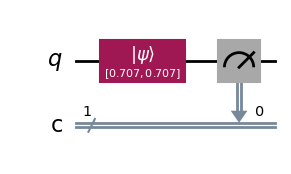

In [16]:
qc = QuantumCircuit(1, 1)
qc.initialize(psi)
qc.measure(0, 0)
qc.draw(output="mpl", style="iqp")

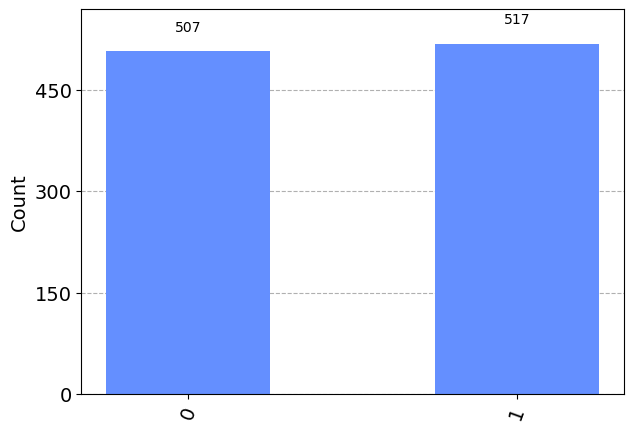

In [17]:
qc = QuantumCircuit(1, 1)
qc.initialize(psi)
qc.measure(0, 0)
results = sim.run(qc, shots=1024).result()
plot_histogram(results.get_counts())

### Example: Measurement in computational basis with 2 qubits

Let
1. $\Pi_{00} = |00\rangle\langle 00|$,
2. $\Pi_{01} = |01\rangle\langle 01|$,
3. $\Pi_{10} = |10\rangle\langle 10|$, and
4. $\Pi_{11} = |11\rangle\langle 11|$,

Then

$$
\{\Pi_{00}, \Pi_{01}, \Pi_{10}, \Pi_{11} \}
$$

forms a set of measurement operators.

In [18]:
# Measurement operators
zz = zero^zero; zo = zero^one; oz = one^zero; oo = one^one
Pi00 = np.outer(zz, zz)
Pi01 = np.outer(zo, zo)
Pi10 = np.outer(oz, oz)
Pi11 = np.outer(oo, oo)
Pis = Pi00 + Pi01 + Pi10 + Pi11
print("Is valid measurement operator:", np.allclose(np.eye(4), Pis.conj().T @ Pis))
Pretty(Pi00 + Pi01 + Pi10 + Pi11)  # Check that it is identity

Is valid measurement operator: True


<IPython.core.display.Latex object>

We'll use two qubits in equal superposition to illustrate what occurs with measurement.

In [19]:
# Create equal superposition
psi = np.array(1/np.sqrt(4.)*zz + 1/np.sqrt(4.)*zo + 1/np.sqrt(4.)*oz + 1/np.sqrt(4.)*oo)
Statevector(psi).draw("latex")

<IPython.core.display.Latex object>

In [20]:
# Perform measurement
ms = [Pi00 @ psi, Pi01 @ psi, Pi10 @ psi, Pi11 @ psi]
ps = [np.linalg.norm(m)**2 for m in ms]   # Probabilities
[f"outcome = {outcome:02b} with probability {prob}" for outcome, prob in zip(range(4), ps)]

['outcome = 00 with probability 0.25',
 'outcome = 01 with probability 0.25',
 'outcome = 10 with probability 0.25',
 'outcome = 11 with probability 0.25']

As before, we can also check that this matches what we obtain with simulation.

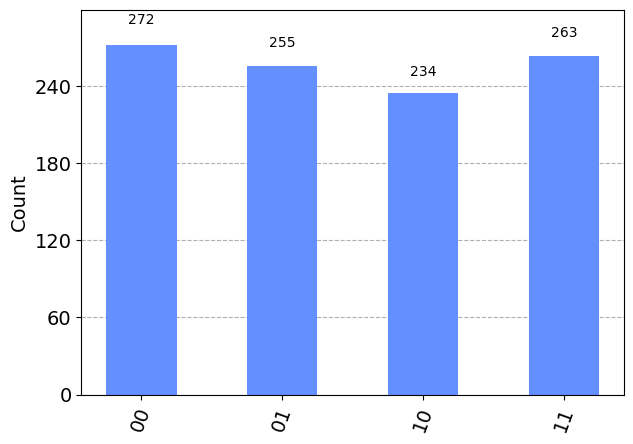

In [21]:
qc = QuantumCircuit(2, 2)
qc.initialize(psi)
qc.measure(0, 0); qc.measure(1, 1)
results = sim.run(qc, shots=1024).result()
plot_histogram(results.get_counts())

### Partial Measurement with Measurement Operators

We can now revist partial measurement. For convenience, we reproduce the circuit with partial measurement below.

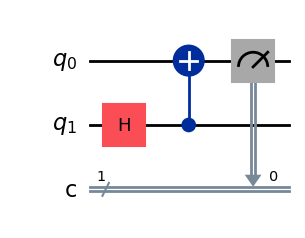

In [22]:
qc_e1.draw(output="mpl", style="iqp")

#### Intuitive reasoning

After the application of the circuit, we have the Bell state

$$
\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle \,.
$$

1. If we observe a $|0\rangle$ after we measure the first qubit, then the second qubit should be a $|0\rangle$ due to entanglement.
2. Similarly, if we observe a $|1\rangle$ after we measure the first qubit, then the second qubit should be a $|1\rangle$, also due to entanglement.

#### More formally with measurement operators

To use the framework of measurement operators to describe the situation of partial measurement, we'll need to concoct a set of measurement operators that do not measure qubit $|q_1\rangle$. Towards this end, let
1. $\Pi_{*0} = |00\rangle\langle 00| + |10\rangle\langle 10|$ and
2. $\Pi_{*1} = |01\rangle\langle 01| + |11\rangle\langle 11|$.

Then

$$
\{\Pi_{*0}, \Pi_{*1} \}
$$

is complete. The * indicates a wildcard, meaning that we do not care what we obtain for the qubit we do not measure.

In [23]:
Pi0s = np.outer(zz, zz) + np.outer(oz, oz) # Pi0s only observes 1st qubit, and we get 0
Pi1s = np.outer(zo, zo) + np.outer(oo, oo) # Pi1s only observes 1st qubit, and we get 1

In [24]:
Pretty(Pi0s + Pi1s)

<IPython.core.display.Latex object>

In [25]:
psi = np.array(1/np.sqrt(2)*zz + 1/np.sqrt(2)*oo)
Statevector(psi).draw("latex")

<IPython.core.display.Latex object>

In [26]:
ms = [
    Pi0s @ psi, 
    Pi1s @ psi, 
]
ps = [np.linalg.norm(m)**2 for m in ms]
# Probabilities of observing for first qubit
[f"outcome = {outcome:01b} with probability {prob}" for outcome, prob in zip([0, 1], ps)]

['outcome = 0 with probability 0.4999999999999999',
 'outcome = 1 with probability 0.4999999999999999']

In [27]:
# If we observe a 0, then the state is
psi = ms[0] / np.linalg.norm(ms[0])
Statevector(psi).draw("latex")

<IPython.core.display.Latex object>

In [28]:
# If we observe a 1, then the state is
psi = ms[1] / np.linalg.norm(ms[1])
Statevector(psi).draw("latex")

<IPython.core.display.Latex object>

## Summary

1. We introduced the notion of measurement operators.
2. We demonstrated how to reason about measurement in multi-qubit systems with measurement operators.